# sobre o gap de tempo necessário para atualizar:

Primeiro um algoritmo bem básico de regressão com dados de algum ano, como 1996 (ser o mais antigo nesse caso é bom), e ver ao longo dos anos, se a qualidade dos resultados se mantém e se é possível determinar quando ele se torna inviável.

Nesse caso uma regressão bem simples, usando um pouco de NLP para as categorias e dados tabulares (gorduras, calorias e proteínas), determinar a quantidade de sódio.

In [1]:
%pylab inline

import pandas as pd
import seaborn as sns
import scipy.stats as stats
import gensim
from sklearn.svm import SVC
from tqdm.notebook import tqdm
from sqlalchemy import create_engine

engine = create_engine('sqlite:///../recept.db')

style.use("material_darker")
figsize(10, 10)

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_sql_query("""
            SELECT recept.id, recept.date, recept.calories,
                recept.fat, recept.protein, recept.rating, recept.sodium
            FROM recept""",
                       engine,  parse_dates=['date']
                      )

In [3]:
df.date = df.date.map(lambda x:x.strftime("%Y"))
df_group_year = df.groupby("date")
# df_features = df_group_year.get_group("1997")

<BarContainer object of 17 artists>

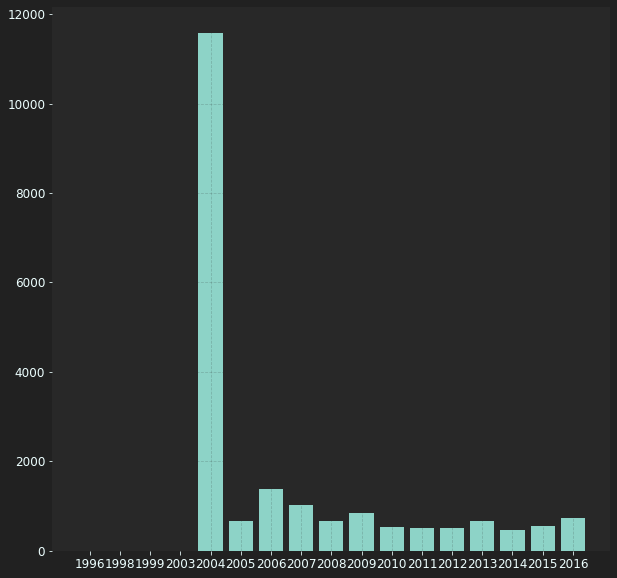

In [4]:
qnt_receitas = list(map(lambda x:len(x), df_group_year.groups.values()))
anos = df_group_year.groups.keys()

bar(x=anos, height=qnt_receitas)

In [5]:
df_features = df_group_year.get_group("2005")

Mudando os planos para 2005 em diante devido a quantidade de receitas disponíveis...

In [6]:
df_features.describe()

,id,calories,fat,protein,rating,sodium
count,661.000000,581.000000,580.000000,580.000000,661.000000,581.000000
mean,10257.193646,482.571429,26.986207,21.943103,3.959909,654.060241
std,5766.688136,469.658772,35.290404,35.212288,0.989241,1135.977899
min,42.000000,2.000000,0.000000,0.000000,0.000000,1.000000
25%,5473.000000,206.000000,9.000000,4.000000,3.750000,106.000000
50%,10503.000000,357.000000,19.000000,9.000000,4.375000,359.000000
75%,15435.000000,607.000000,35.000000,30.000000,4.375000,913.000000
max,20128.000000,5656.000000,599.000000,372.000000,5.000000,16813.000000


In [7]:
df_features = df_features.dropna()

In [8]:
features = df_features[["fat", "calories", "sodium", "protein", "rating"]]

<AxesSubplot:>

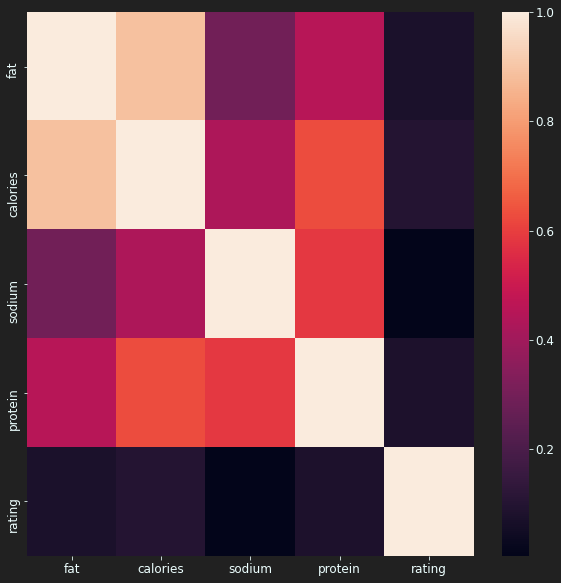

In [9]:
sns.heatmap(features.corr())

In [10]:
features.pop("rating");

removendo rating (baixíssima correlação com o resto)...

<AxesSubplot:>

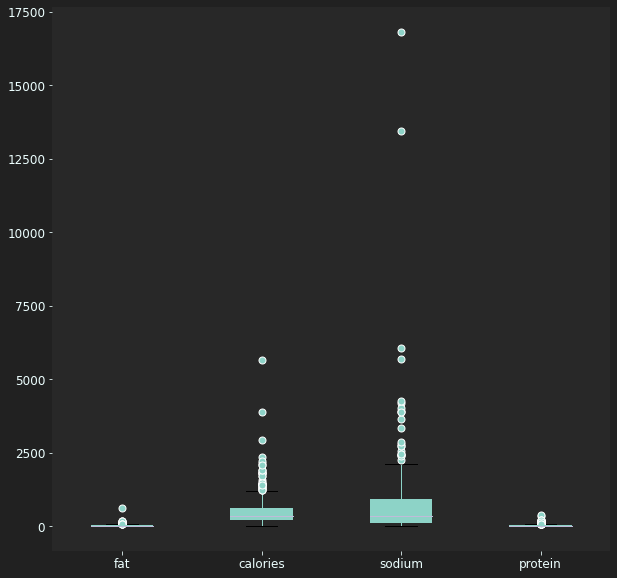

In [11]:
features.plot.box()

muito outliers... utilizando método interquartile

In [12]:
def interquartile(df):
    
    Q1 = df.quantile(q=.25)
    Q3 = df.quantile(q=.75)
    IQR = df.apply(stats.iqr)

    return df[~((df < (Q1-1.5*IQR)) | (df > (Q3+1.5*IQR))).any(axis=1)]

features = interquartile(features)

<AxesSubplot:>

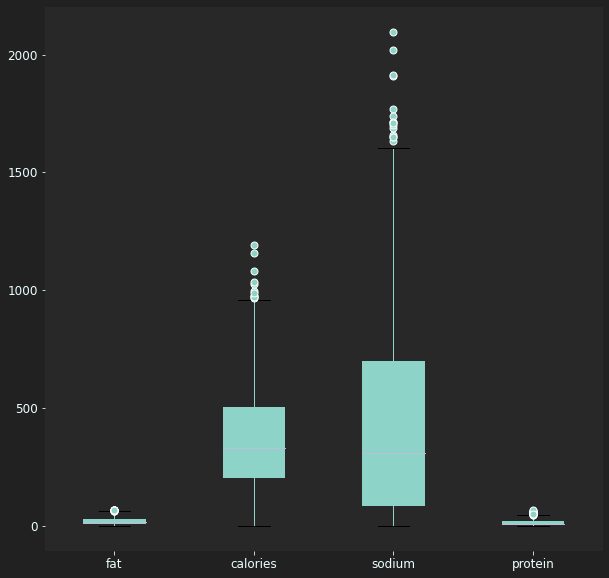

In [13]:
features.plot.box()

In [14]:
df_features[["fat", "calories", "sodium", "protein"]] = features

## Treinamento e comparações ao longo do tempo

In [51]:
df_train = df_features.dropna()

X_train = df_train[["calories", "fat", "protein"]]
Y_train = df_train.sodium

In [52]:
from sklearn.svm import SVR
svr = SVR()
svr.fit(X_train, Y_train)

SVR()

In [53]:
svr.score(X_train, Y_train)

-0.02894053270942032

In [54]:
def pipeline(df_group_year, year):
    features = df_group_year.get_group(f"{year}")[["calories", "fat", "protein", "sodium"]].dropna()
    features = interquartile(features)
    X = features[["calories", "fat", "protein"]]
    Y = features.sodium
    return X, Y

In [55]:
x_2010, y_2010 = pipeline(df_group_year, 2016)

In [56]:
svr.score(x_2010, y_2010)

-0.10208418265720698

In [57]:
scores = []
years = []
for year in list(df_group_year.groups.keys())[1:]:
    X, Y = pipeline(df_group_year, year)
    score = svr.score(X, Y)
    print(year, score)
    years.append(year)
    scores.append(score)

1998 -9.219345003088735
1999 -0.9208085117877056
2003 -0.22552931814218447
2004 0.07255735595072854
2005 -0.02894053270942032
2006 0.00791903718680953
2007 0.06948291084059821
2008 0.03745806279197639
2009 0.04978655657863762
2010 0.05738538533507631
2011 0.05911112880468128
2012 0.02809624567180946
2013 0.03415937785726686
2014 0.047750808709003945
2015 -0.051563969298041856
2016 -0.10208418265720698


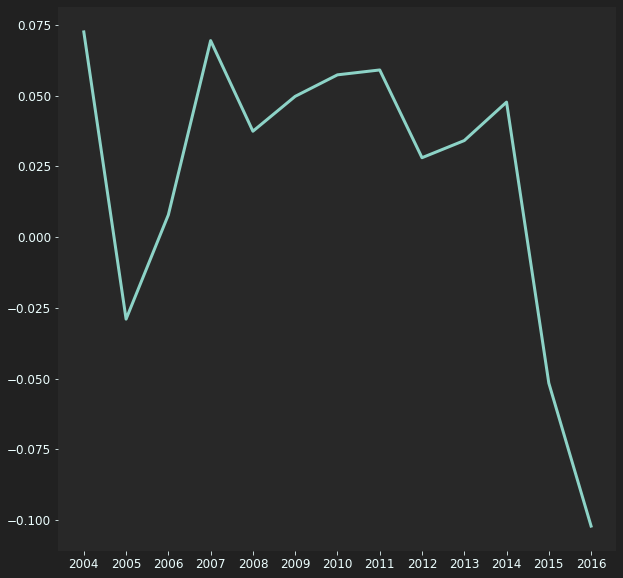

In [58]:
plot(scores[3:])
xticks(range(len(years[3:])), years[3:]);